In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from isochrones import get_ichrone
import numpy as np
%config InlineBackend.figure_format = "retina"
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
plt.rc('font',family='Times New Roman',size=20)
scatter_kwargs = {"zorder":50}

In [2]:
'''
The HZ boundaries defined by Kopparapu et al. 2013
https://iopscience.iop.org/article/10.1088/0004-637X/765/2/131
'''

coef =  np.array([
        [1.7763, 1.4335e-4, 3.3954e-9, -7.6364e-12, -1.1950e-15], #re_venus
        [1.0385, 1.2456e-4, 1.4612e-8, -7.6345e-12, -1.7511e-15], #ru_green
        [1.0146, 8.1884e-5, 1.9394e-9, -4.3618e-12, -6.8260e-16], #mo_green
        [0,0,0,0,0], #maximum_greenhouse
        [0.3207, 5.4471e-5, 1.5275e-9, -2.1709e-12, -3.8282e-16]] #ear_mars
        )
hz_coef = pd.DataFrame( coef.T,columns = 
                        [
                        'recent_venus',
                        'runaway_greenhouse',
                        'moist_greenhouse',
                        'maximum_greenhouse',
                        'early_mars'
                        ]
                      )


def cal_hz(teff,L,inner = 'recent_venus', outer = 'early_mars'):
    t0 = teff - 5780
    t = np.array([1,t0,t0**2,t0**3,t0**4])
    return np.sqrt(L/(t*hz_coef[inner].values).sum()), np.sqrt(L/(t*hz_coef[outer].values).sum())


In [32]:
tic = pd.read_csv('tic_complete.csv')
tic.drop(columns=['Unnamed: 0'],inplace=True)
tic.dropna(subset=['Lum'],inplace=True)
tic.isna().sum()

GAIA       127
TWOMASS    140
ra           0
dec          0
plx          0
Vmag         0
Kmag         8
Teff         0
Lum          0
dtype: int64

Text(0.5, 0, '$T_\\mathrm{eff}$')

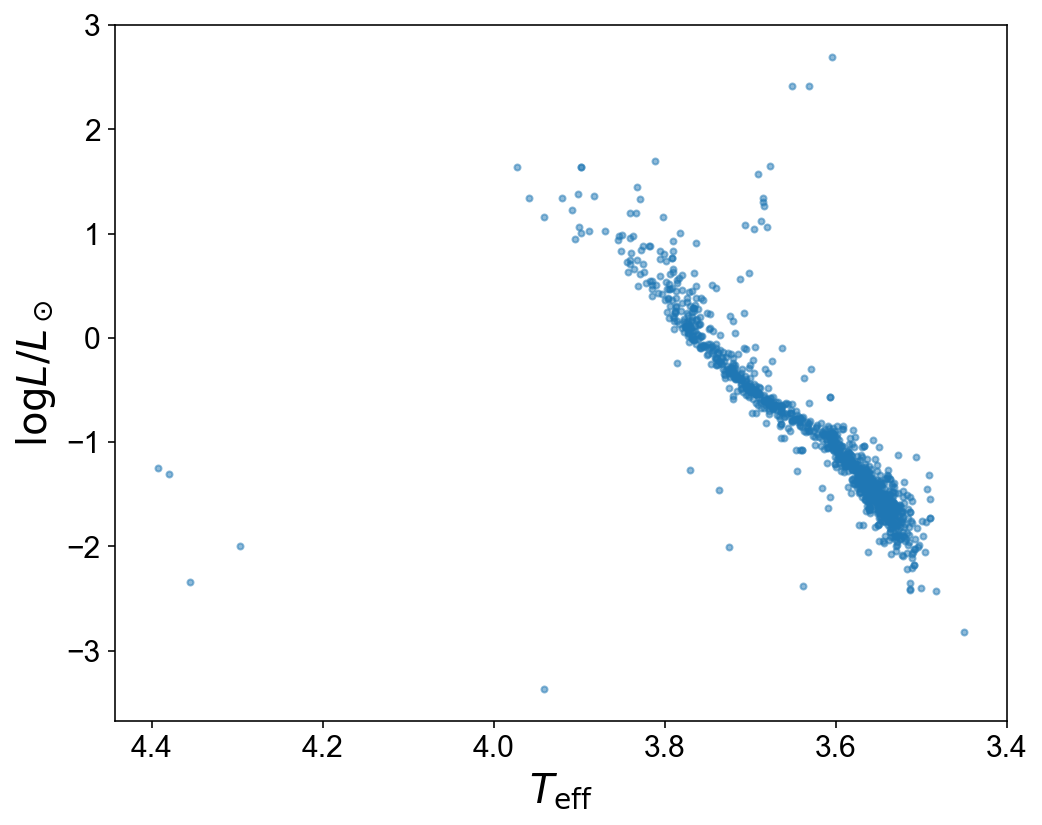

In [257]:
fig,axs = plt.subplots(figsize=(8,6.4))
axs.scatter(np.log10(tic.Teff),np.log10(tic.Lum),marker='.',alpha=0.5)
axs.invert_xaxis()
axs.set_ylabel('$\log L/L_\odot$',fontsize=20)
axs.set_xlabel('$T_\mathrm{eff}$',fontsize=20)

There are some apparent white dwarfs in our sample, let's eliminate them.

In [33]:
m = np.log10(tic.Teff)>3.9
m &= (np.log10(tic.Lum))<-1
tic = tic[~m]
tic.reset_index(inplace=True,drop=True)

## Sky map of TICs that V<12

We first make some plots of the 1100+ sources whose V-mag are brighter than 12.

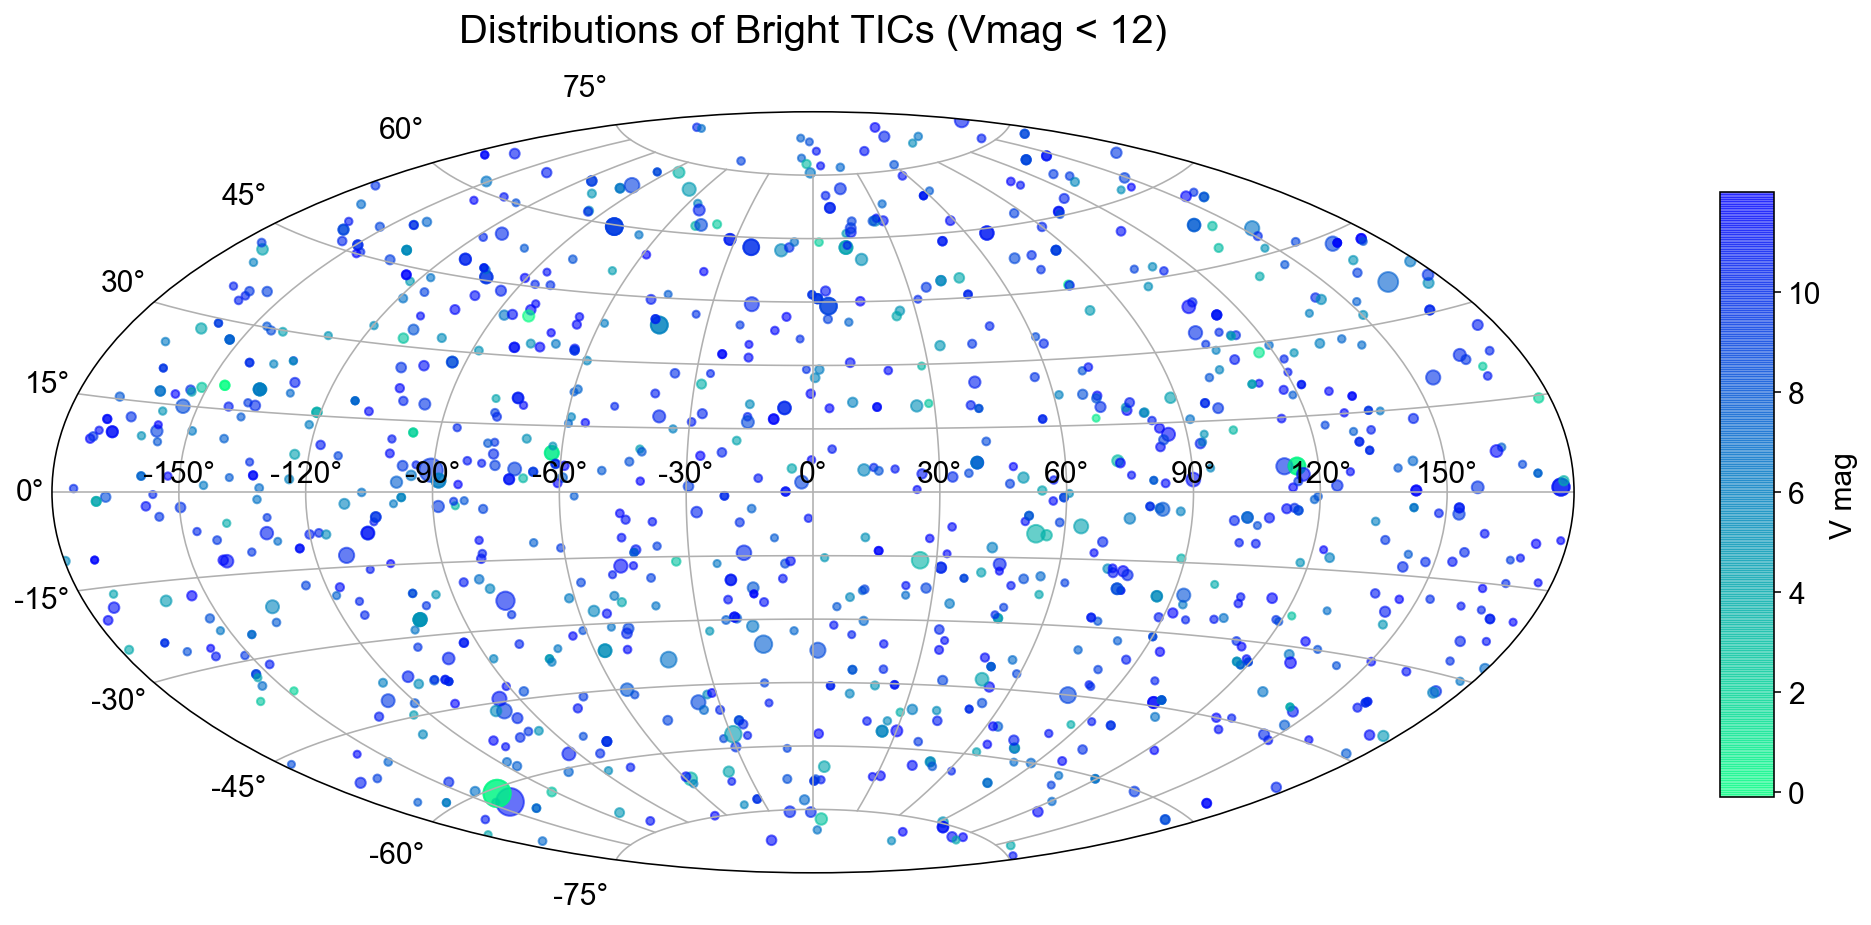

In [221]:
from astropy import units as u
from astropy.coordinates import SkyCoord
plt.rc('font',family='Arial',size=15,weight='normal')
c = SkyCoord(ra=tic.ra*u.degree, dec=tic.dec*u.degree, frame='icrs')
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111,projection='aitoff')

cbar_ax = fig.add_axes([0.89, 0.2, 0.025, 0.60])
ax.set_title("Distributions of Bright TICs (Vmag < 12)",pad=35,fontsize=20)
im = ax.scatter(ra_rad, dec_rad,marker='.',alpha=0.6,c=tic.Vmag,s=tic.plx,cmap='winter_r')
fig.colorbar(im,cax = cbar_ax, label='V mag')
ax.grid(True)
fig.subplots_adjust(left=0.02,right=0.92,wspace = 0.08)

plt.savefig('./hz/aitoff_full.pdf',dpi=300)

## H-R diagram of bright TICs

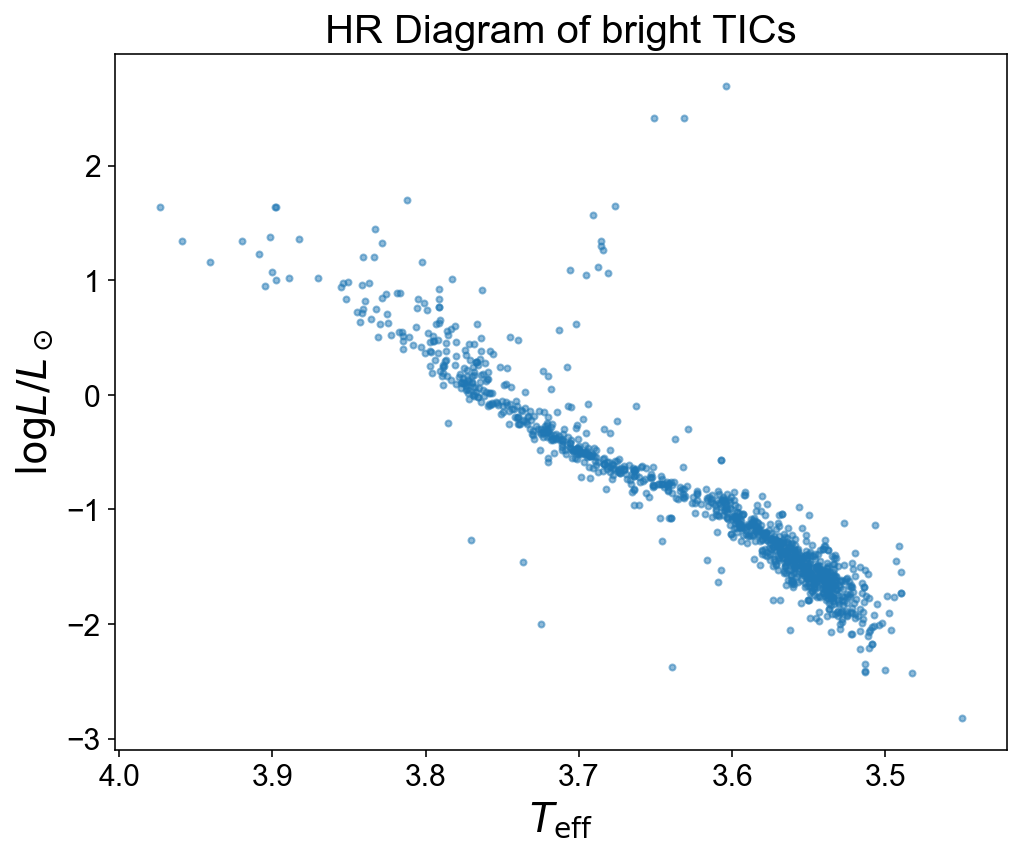

In [77]:

fig,axs = plt.subplots(figsize=(8,6.4))

axs.scatter(np.log10(tic.Teff),np.log10(tic.Lum),marker='.',alpha=0.5)
axs.invert_xaxis()
axs.set_ylabel('$\log L/L_\odot$',fontsize=20)
axs.set_xlabel('$T_\mathrm{eff}$',fontsize=20)
#axs.set_xlim()
axs.set_title('HR Diagram of bright TICs',fontsize=20)

plt.savefig('./hz/HR_full.pdf',dpi=300)

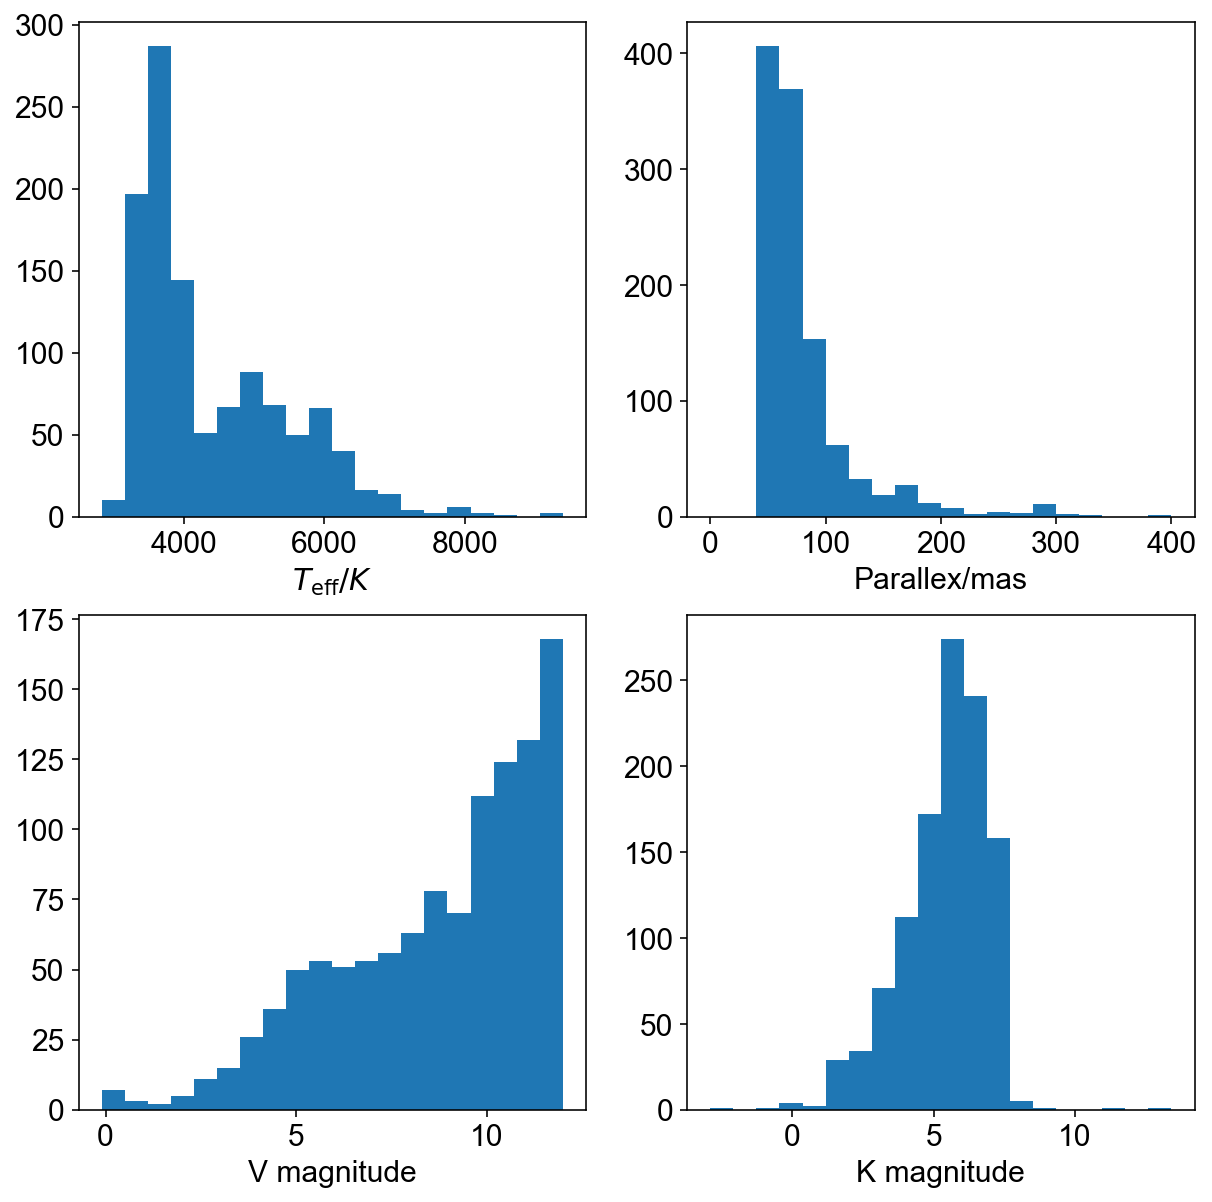

In [87]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
ax1,ax2,ax3,ax4 = axs.ravel()

ax1.hist(tic.Teff,bins=20)
ax1.set_xlabel('$T_\mathrm{eff}/K$')
ax2.hist(tic.plx,bins=20,range=(0,400))
ax2.set_xlabel('Parallex/mas')
ax3.hist(tic.Vmag,bins=20)
ax3.set_xlabel('V magnitude')
ax4.hist(tic.Kmag,bins=20)
ax4.set_xlabel('K magnitude')

plt.savefig('./hz/stellar_prop_full.pdf',dpi=300)

Next we calculate the HZ boundaries, inner as Recent Venus and outer as Early Mars, for each TICs and their angular extent ,respectively. Then we select 500 candidates with widest HZ.

/Users/neptune/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


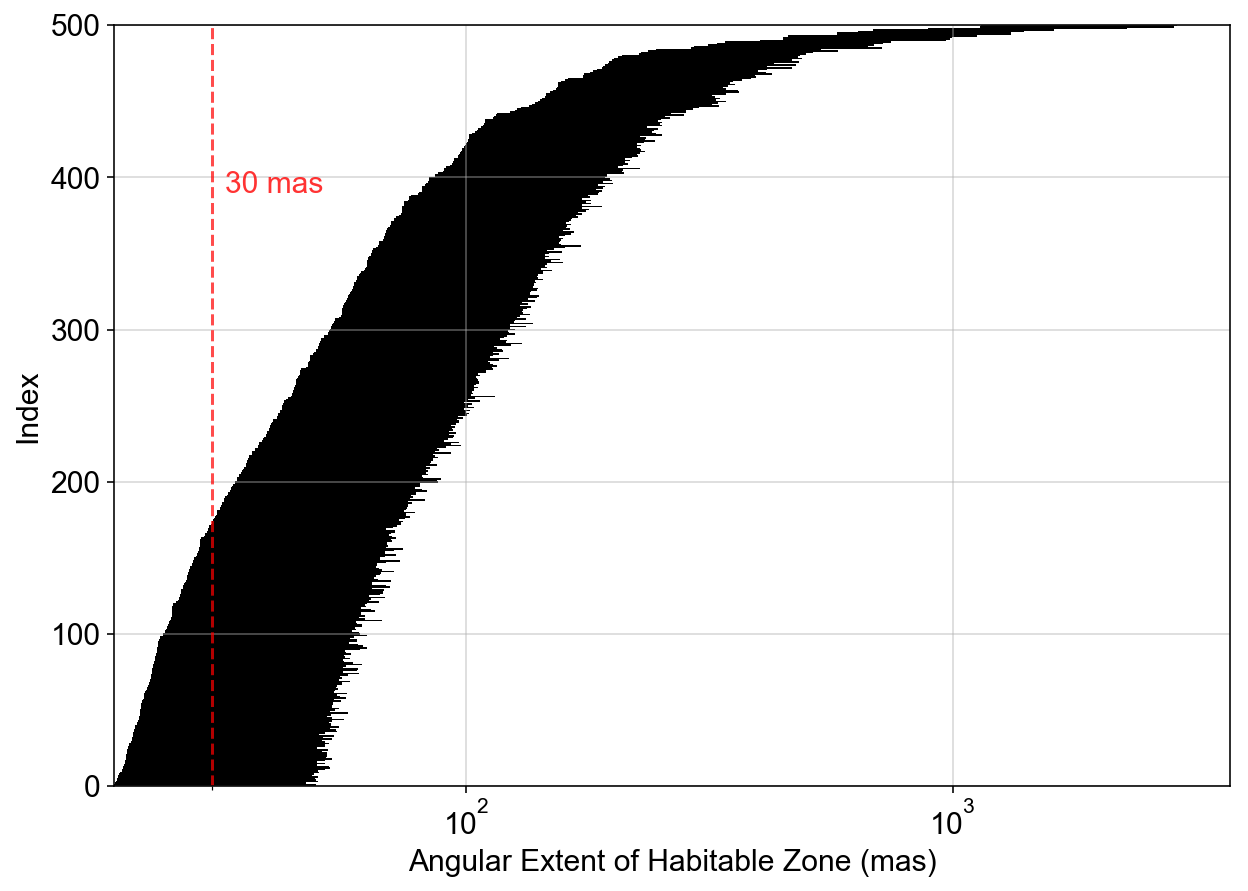

In [228]:
inner, outer= cal_hz(teff=tic.Teff,L=tic.Lum)
plx = tic.plx.values
tic['hz_inner'] = inner*plx/1000
tic['hz_outer'] = outer*plx/1000

tic_fil = tic.sort_values('hz_inner')
tic_fil.reset_index(inplace=True,drop=True)
tic_fil = tic_fil[-500:]

fig,axs = plt.subplots(figsize=(10,7))
axs.barh(y=np.arange(len(tic_fil))+1,
        height=1,
        left=tic_fil.hz_inner*1e3,
        width=(tic_fil.hz_outer-tic_fil.hz_inner)*1e3,
        color='black',
        alpha=1)
axs.set_xscale('log')
#axs.set_ylim([0,100])
axs.set_ylim([0,500])
axs.set_xlabel('Angular Extent of Habitable Zone (mas)')
axs.set_ylabel('Index')
plt.axvline(30,linestyle='--',color='red',alpha=0.7)
axs.text(32,390,'30 mas',color='red',alpha=0.8)
axs.set_xticks([30],[30])
axs.grid(True,alpha=0.5)
plt.savefig('./hz/hz_angular_500.pdf',dpi=100)

## Filtered stars prop

In [147]:
tic_fil['d'] = 1000./tic_fil.plx
tic_fil['hz_ang_sep'] = (tic_fil.hz_outer-tic_fil.hz_inner) * 1000.

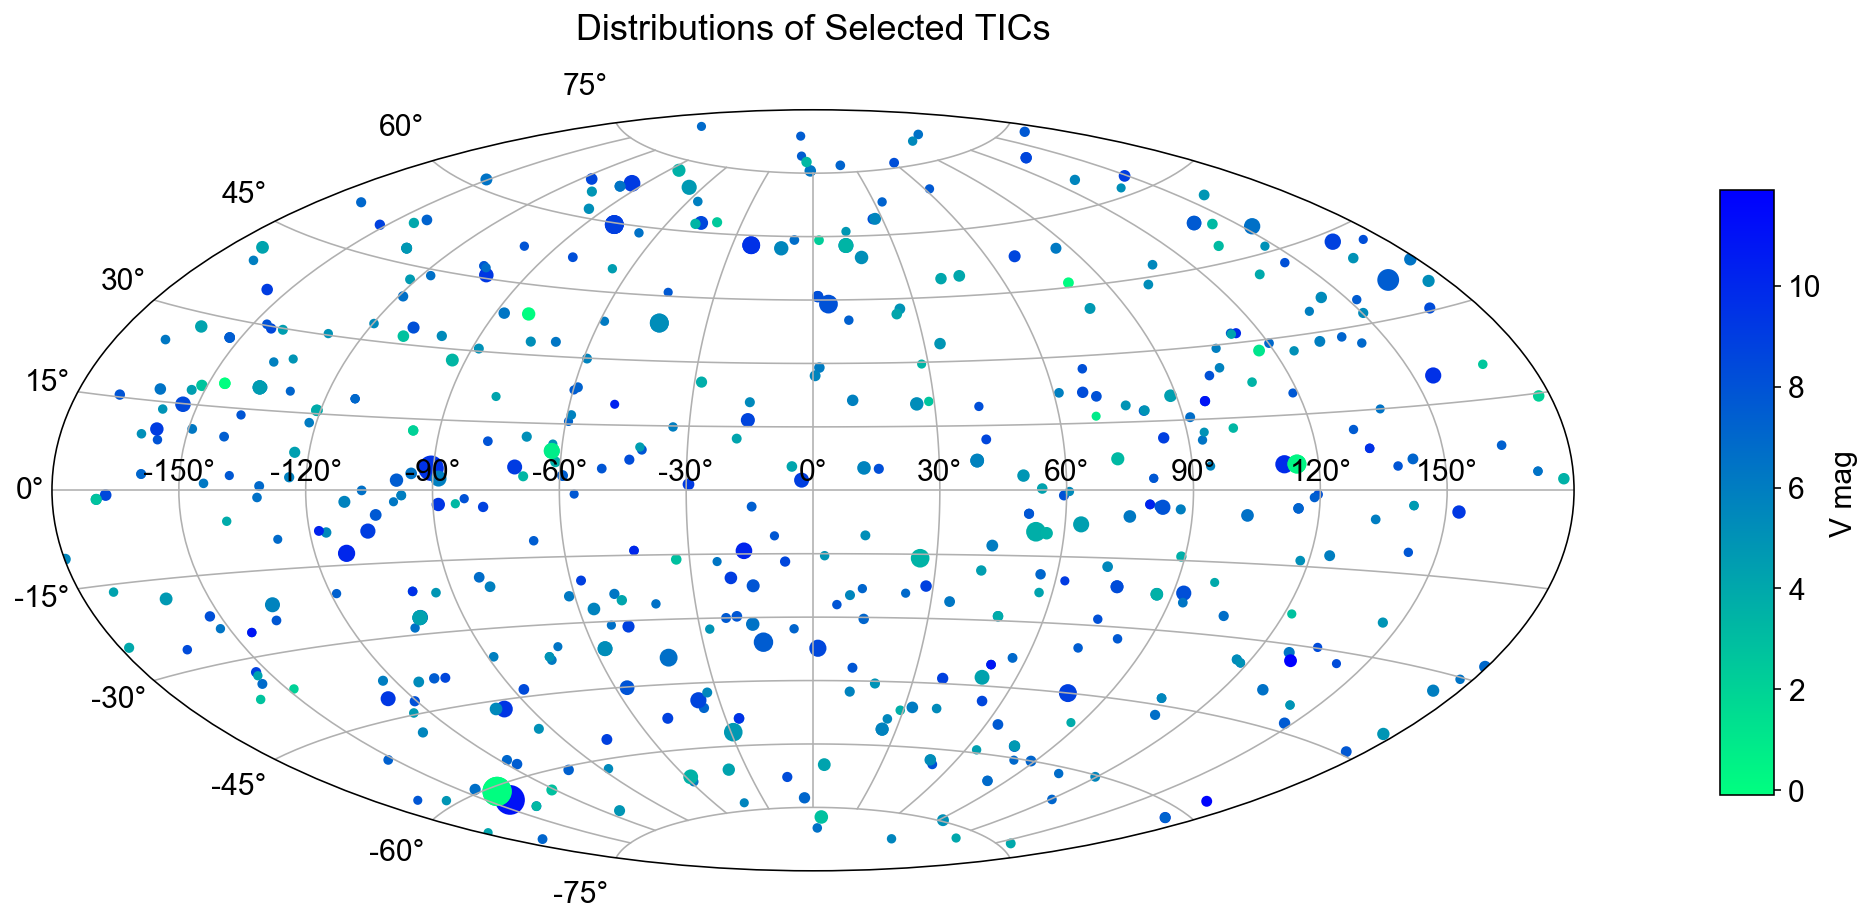

In [229]:
from astropy import units as u
from astropy.coordinates import SkyCoord
plt.rc('font',family='Arial',size=15)
c = SkyCoord(ra=tic_fil.ra*u.degree, dec=tic_fil.dec*u.degree, frame='icrs')
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111,projection='aitoff')

cbar_ax = fig.add_axes([0.89, 0.2, 0.025, 0.60])
ax.set_title("Distributions of Selected TICs",pad=35)
im = ax.scatter(ra_rad, dec_rad,marker='.',alpha=1,c=tic_fil.Vmag,s=tic_fil.plx,cmap='winter_r')
fig.colorbar(im,cax = cbar_ax, label='V mag')
ax.grid(True)
fig.subplots_adjust(left=0.02,right=0.92,wspace = 0.08)

plt.savefig('./hz/aitoff_500.pdf',dpi=300)

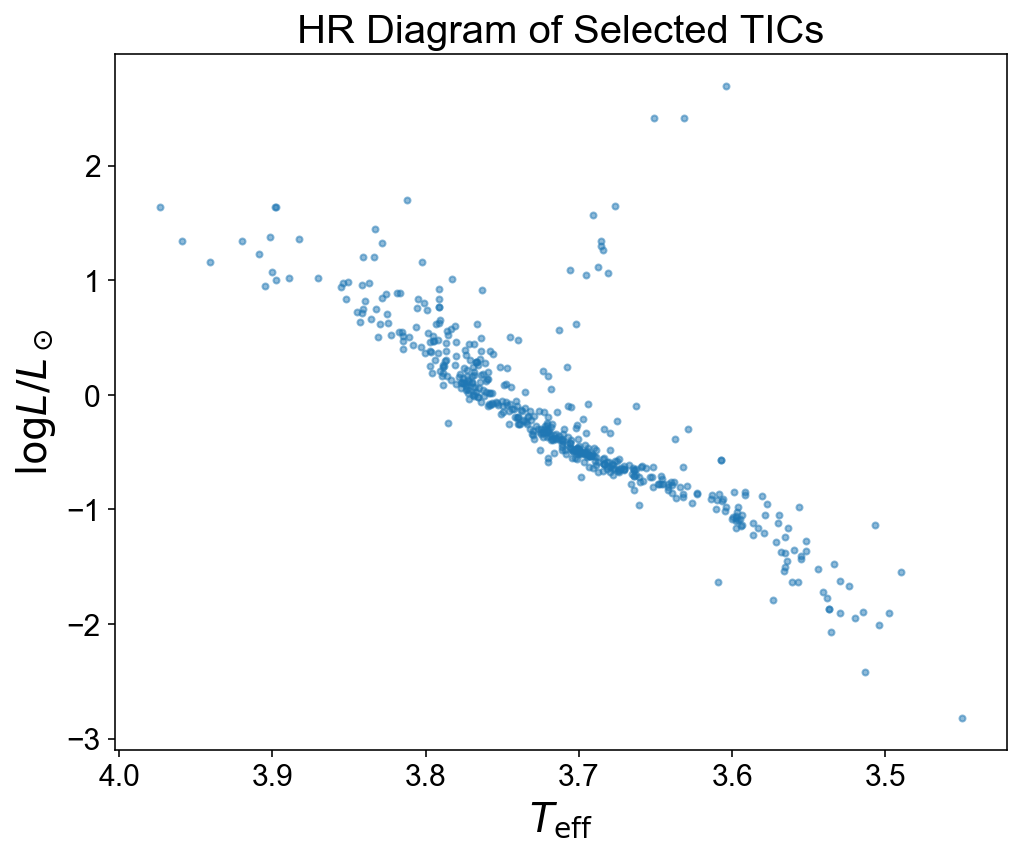

In [230]:
fig,axs = plt.subplots(figsize=(8,6.4))

axs.scatter(np.log10(tic_fil.Teff),np.log10(tic_fil.Lum),marker='.',alpha=0.5)
#axs.scatter(data.Teff,data.lum,marker='.',alpha=0.5)
axs.invert_xaxis()
axs.set_ylabel('$\log L/L_\odot$',fontsize=20)
axs.set_xlabel('$T_\mathrm{eff}$',fontsize=20)
#axs.set_xlim()
axs.set_title('HR Diagram of Selected TICs',fontsize=20)

plt.savefig('./hz/HR_500.pdf',dpi=300)

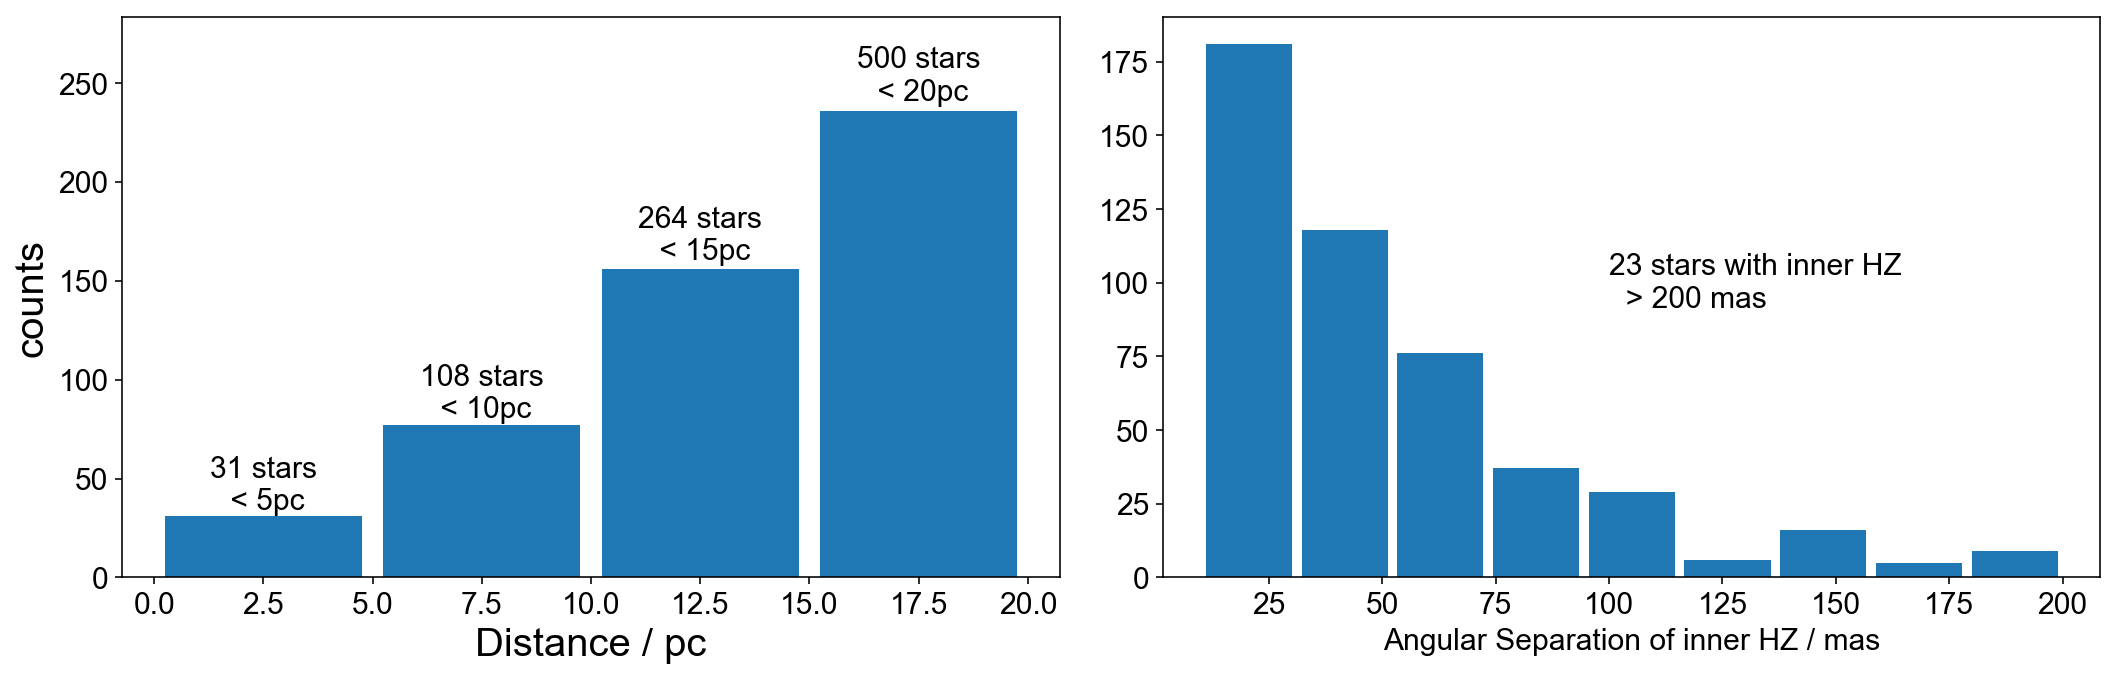

In [219]:

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ax1,ax2 = axs.ravel()
num,bins,_=ax1.hist(tic_fil.d,histtype='bar',rwidth=0.9,bins=np.linspace(0,20,5))

N = 0
for n, b_left, b_right in zip(num,bins,bins[1:]):
    N += n
    ax1.text(b_left+2.5,n*1.01,'%d' % int(N) +' stars\n < ' + '%d' % int(b_right) + 'pc',
             ha='center',
             va='bottom')

ax1.set_xlabel('Distance / pc',fontsize=20)
ax1.set_ylim([0,1.2*max(num)])
ax1.set_ylabel('counts',fontsize=20)
bins = np.linspace(10,200,10)
ax2.hist(tic_fil.hz_inner *1000,range=(0,200),rwidth=0.9,bins=bins)
ax2.set_xlabel('Angular Separation of inner HZ / mas',fontsize=15)
ax2.text(100,100,'23 stars with inner HZ \n  > 200 mas',va='center')

plt.tight_layout()
plt.savefig('./hz/hz_plx.pdf',dpi=300)

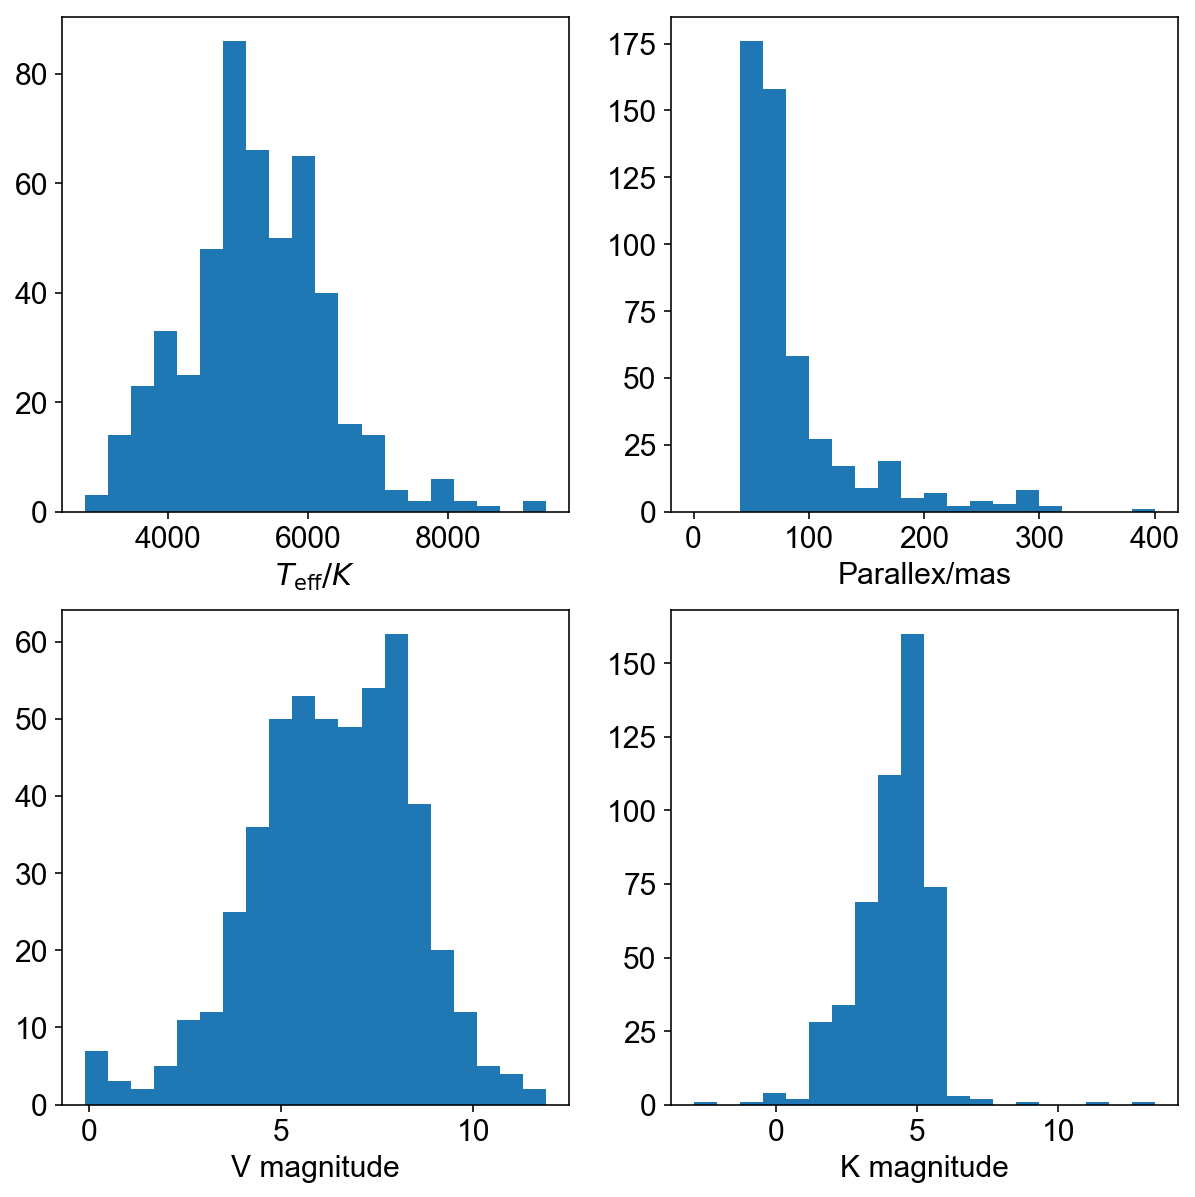

In [100]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
ax1,ax2,ax3,ax4 = axs.ravel()

ax1.hist(tic_fil.Teff,bins=20)
ax1.set_xlabel('$T_\mathrm{eff}/K$')
ax2.hist(tic_fil.plx,bins=20,range=(0,400))
ax2.set_xlabel('Parallex/mas')
ax3.hist(tic_fil.Vmag,bins=20)
ax3.set_xlabel('V magnitude')
ax4.hist(tic_fil.Kmag,bins=20)
ax4.set_xlabel('K magnitude')

plt.savefig('./hz/stellar_prop_500.pdf',dpi=300)